In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import json, os, ast, joblib, warnings
from itertools import product
from sklearn.base import clone
import matplotlib.ticker as mticker

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [29]:
def getAUC(model, xTest, yTest):
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(xTest)[:, 1]
    else:
        y_score = model.decision_function(xTest)
    
    return y_score, roc_auc_score(yTest, y_score)

# EXTRAINDO DADOS

In [30]:
df = pd.read_csv('files/Model.csv')
df['data'] = df.data.apply(ast.literal_eval)
df

,min,std,median,last,mean,max,first,alcohol,data
0,23250,742.479449,23281.0,23275,23557.723404,26216,23534,False,"[23534, 24013, 26216, 26172, 26108, 25037, 240..."
1,23536,748.382989,23585.0,23596,23877.446809,26143,23797,False,"[23797, 24164, 26134, 26143, 26142, 26120, 253..."
2,23695,749.516802,23765.0,23801,24055.574468,26359,23899,False,"[23899, 24905, 26249, 26359, 26335, 26225, 254..."
3,23523,941.151691,23586.0,23553,24066.489362,26285,23967,False,"[23967, 24384, 26285, 26237, 26228, 26188, 261..."
4,23826,715.797389,23938.0,23943,24297.723404,26269,23859,False,"[23859, 24287, 26269, 26188, 26115, 25477, 245..."
...,...,...,...,...,...,...,...,...,...
215,17667,178.611054,18041.0,18298,18025.531915,18298,17667,False,"[17667, 17719, 17742, 17751, 17752, 17787, 178..."
216,16046,875.705481,17592.0,18029,17533.319149,20518,18480,True,"[18480, 18518, 18389, 18616, 18676, 19648, 205..."
217,15173,1063.603226,17106.0,17682,17032.446809,19850,18354,True,"[18354, 18382, 18801, 19472, 19850, 19176, 168..."
218,11119,1488.948178,14135.0,15251,13937.787234,17507,17507,True,"[17507, 17507, 16270, 15272, 13966, 13690, 132..."


In [31]:
xData = df.drop(columns=['data', 'alcohol'])
yData = df['alcohol'].values

N_STATES = len(xData.columns)
print('n states: ', N_STATES)

xData

n states:  7


,min,std,median,last,mean,max,first
0,23250,742.479449,23281.0,23275,23557.723404,26216,23534
1,23536,748.382989,23585.0,23596,23877.446809,26143,23797
2,23695,749.516802,23765.0,23801,24055.574468,26359,23899
3,23523,941.151691,23586.0,23553,24066.489362,26285,23967
4,23826,715.797389,23938.0,23943,24297.723404,26269,23859
...,...,...,...,...,...,...,...
215,17667,178.611054,18041.0,18298,18025.531915,18298,17667
216,16046,875.705481,17592.0,18029,17533.319149,20518,18480
217,15173,1063.603226,17106.0,17682,17032.446809,19850,18354
218,11119,1488.948178,14135.0,15251,13937.787234,17507,17507


# SELECIONANDO MODELO

In [32]:
class ModelSelector:
    options = {
        'logistic_regression': {
            'model': LogisticRegression(),
            'params': {
                'C': [0.1, 0.25, 0.5, 0.75, 1, 3, 5, 7, 10],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga'],
                'max_iter': [50, 100, 200, 500, 800, 1000, 1500, 2000, 3000, 4000, 10000, 15000]
            }
        },
        'knn': {
            'model': KNeighborsClassifier(n_neighbors=2), # Base solicitado
            'params': {
                'n_neighbors': [2, 3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            }
        },
        'svm': {
            'model': SVC(probability=True, random_state=42),
            'params': {
                'C': [0.1, 1, 10, 100],
                'kernel': ['rbf', 'linear', 'poly'],
                'gamma': ['scale', 'auto']
            }
        },
        'random_forest': {
            'model': RandomForestClassifier(n_estimators=300, random_state=42),
            'params': {
                'n_estimators': [100, 200, 300, 500],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        },
        'gradient_boosting': {
            'model': GradientBoostingClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7]
            }
        },
        'decision_tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 10, 20, 30, 50],
                'min_samples_split': [2, 5, 10]
            }
        },
        'naive_bayes': {
            'model': GaussianNB(),
            'params': {
                'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
            }
        }
    }

    def get(self):
        model = Pipeline([
            ('scaler', StandardScaler()), 
            ('model', self.selected['model'])
        ])
        
        raw_params = self.selected['params']
        params = {f'model__{k}': v for k, v in raw_params.items()}
        return model, params

    def __init__(self, name: str):
        self.chosen   = name
        self.selected = self.options[name]


selector = ModelSelector('logistic_regression')
model, params = selector.get()
model

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


# VALIDAÇAÕ CRUZADA

In [33]:
K_CV = 5

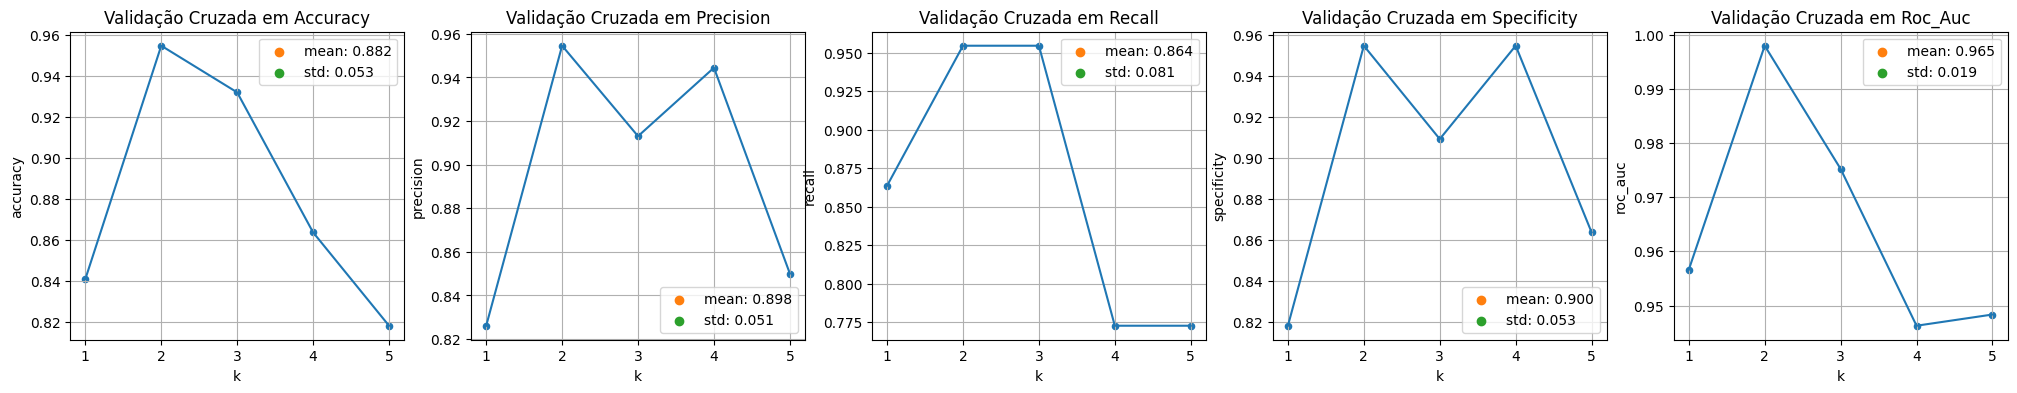

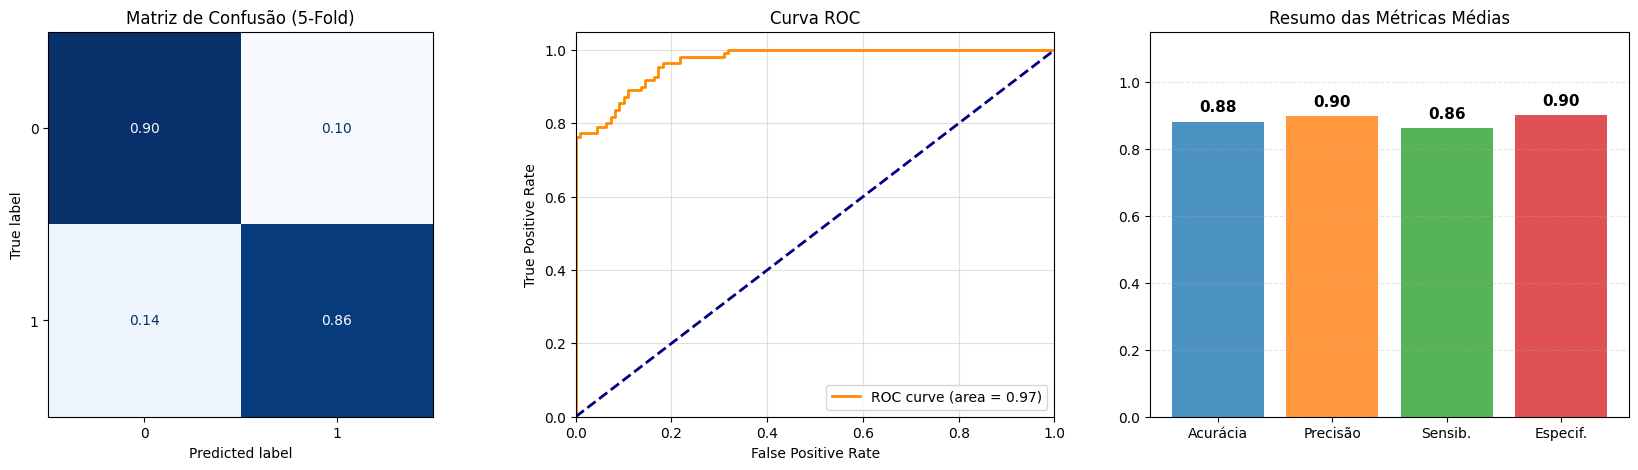

,name,values,mean,std,min,max,k0,k1,k2,k3,k4
0,accuracy,"[0.8409090909090909, 0.9545454545454546, 0.931...",0.881818,0.052617,0.818182,0.954545,0.840909,0.954545,0.931818,0.863636,0.818182
1,precision,"[0.8260869565217391, 0.9545454545454546, 0.913...",0.897624,0.051099,0.826087,0.954545,0.826087,0.954545,0.913043,0.944444,0.850000
2,recall,"[0.8636363636363636, 0.9545454545454546, 0.954...",0.863636,0.081312,0.772727,0.954545,0.863636,0.954545,0.954545,0.772727,0.772727
3,specificity,"[0.8181818181818182, 0.9545454545454546, 0.909...",0.900000,0.053009,0.818182,0.954545,0.818182,0.954545,0.909091,0.954545,0.863636
4,roc_auc,"[0.9566115702479339, 0.9979338842975207, 0.975...",0.964876,0.019426,0.946281,0.997934,0.956612,0.997934,0.975207,0.946281,0.948347


ACCURACY: 88.18% (±5.26%)
PRECISION: 89.76% (±5.11%)
RECALL: 86.36% (±8.13%)
SPECIFICITY: 90.00% (±5.30%)
ROC_AUC: 96.49% (±1.94%)


In [34]:
class CrossValidation:
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall':  'recall',
        'specificity': make_scorer(recall_score, pos_label=0),
        'roc_auc': 'roc_auc'
    }
    
    def __init__(self, model, xData, yData, k=4, seed=42):
        self.selected = str(model.__class__.__name__)
        self.model = clone(model)
        self.xData = xData
        self.yData = yData
        self.scores = {}
        self.seed   = seed
        self.k = k

    def update(self):
        self.cv_splitter = StratifiedKFold(n_splits=self.k, shuffle=True, random_state=self.seed)

        result = cross_validate(**{
            'estimator': self.model,
            'X':  self.xData,
            'y':  self.yData,
            'cv': self.cv_splitter,
            'scoring': self.scoring,
            'return_train_score': False
        })
        self.scores = [self.process(result, metric) for metric in self.scoring.keys()]
        self.accuracy    = np.mean(self.scores[0]['values'])
        self.precision   = np.mean(self.scores[1]['values'])
        self.recall      = np.mean(self.scores[2]['values'])
        self.specificity = np.mean(self.scores[3]['values'])
        self.auc         = np.mean(self.scores[4]['values'])

        data = []
        for metric in self.scores:           
            for i, value in enumerate(metric.get('values')):
                metric[f'k{i}'] = value
            data.append(metric)
        self.df = pd.DataFrame(data)
        

    def process(self, result, key):
        values = result[f'test_{key}']

        return {
            'name': key,
            'values': values,
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values)
        }
    
    def info(self):
        return {
            'model': self.selected,
            'accuracy': self.accuracy,
            'precision': self.precision,
            'recall': self.recall,
            'specificity': self.specificity,
            'auc': self.auc,
        }

    def print(self):
        display(self.df)
        
        for metric in self.scores:
            name = metric.get('name').upper()
            mean = metric.get('mean')*100
            std  = metric.get('std')
            print(f'{name}: {mean:.2f}% (±{std*100:.2f}%)')

    def plot(self):
        plt.figure(figsize=(25, 4))
        for i, row in self.df.iterrows():
            metric, values = row['name'], row['values']
            kData = [j+1 for j in range(self.k)]

            plt.subplot(1, len(self.df), i+1)
            plt.plot(kData, values)
            plt.scatter(kData, values, s=20)
            for info in ['mean', 'std']:
                plt.scatter([], [], label=f'{info}: {row[info]:.3f}')
            plt.xticks(kData); plt.title(f'Validação Cruzada em {metric.title()}')
            plt.grid(); plt.xlabel('k'); plt.ylabel(metric); plt.legend()
        plt.show()

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5)) 
        y_pred = cross_val_predict(self.model, self.xData, self.yData, cv=self.cv_splitter)
        cm     = confusion_matrix(self.yData, y_pred, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', values_format='.2f', ax=ax1, colorbar=False)
        ax1.set_title(f'Matriz de Confusão ({self.k}-Fold)')

        try:
            y_probas = cross_val_predict(self.model, self.xData, self.yData, cv=self.cv_splitter, method='predict_proba')
            y_scores = y_probas[:, 1] 
        except AttributeError:
            y_scores = cross_val_predict(self.model, self.xData, self.yData, cv=self.cv_splitter, method='decision_function')
        
        fpr, tpr, _ = roc_curve(self.yData, y_scores)
        roc_auc     = auc(fpr, tpr)
        ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax2.set_xlim([0.0, 1.0]); ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('False Positive Rate'); ax2.set_ylabel('True Positive Rate')
        ax2.set_title('Curva ROC'); ax2.legend(loc="lower right"); ax2.grid(alpha=0.4)
        
        metrics_labels = ['Acurácia', 'Precisão', 'Sensib.', 'Especif.']
        metrics_values = [self.accuracy, self.precision, self.recall, self.specificity]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        bars   = ax3.bar(metrics_labels, metrics_values, color=colors, alpha=0.8)
        ax3.set_ylim(0, 1.15); ax3.set_title('Resumo das Métricas Médias')
        ax3.grid(axis='y', alpha=0.3, linestyle='--')

        for bar in bars:
            ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height()+.02, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        plt.show()


cross = CrossValidation(model, xData, yData, k=K_CV)
cross.update()
cross.plot()
cross.print()

# AVALIAÇÃO GAUSSIANA
O valor mais provável em uma distribuição gaussiana é a média, com a relação

$$\mu \pm t\cdot\frac{\sigma_a}{\sqrt{n}}$$

- $\sigma_a$ é o desvio padrão amostral, considerando $n-1$ graus de liberade (ddof no numpy)
- $\mu$ é a média
- $t$ é o t_student para corrigir a amostra com $n$-1 e aqui vamos adotar a tabela para 95% de confiança (os dados vão cair em um intervalo $\pm$ ... com 95% de confiança) 

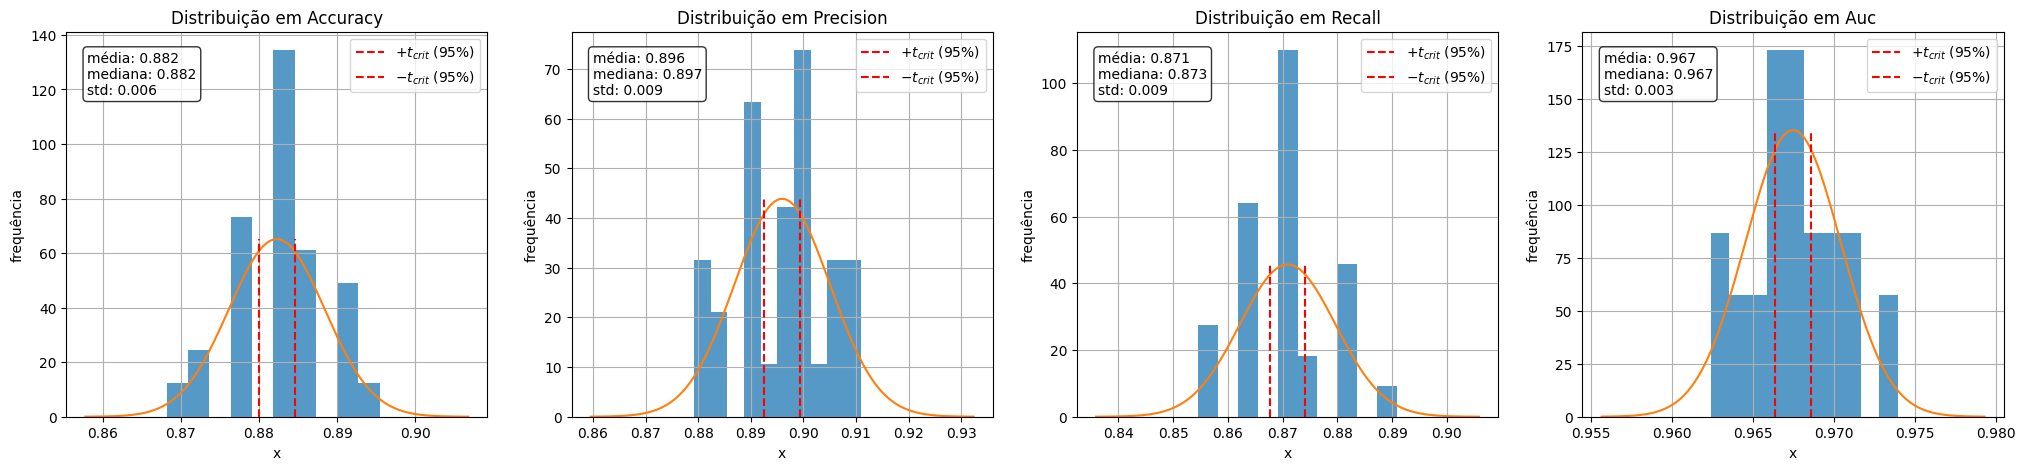

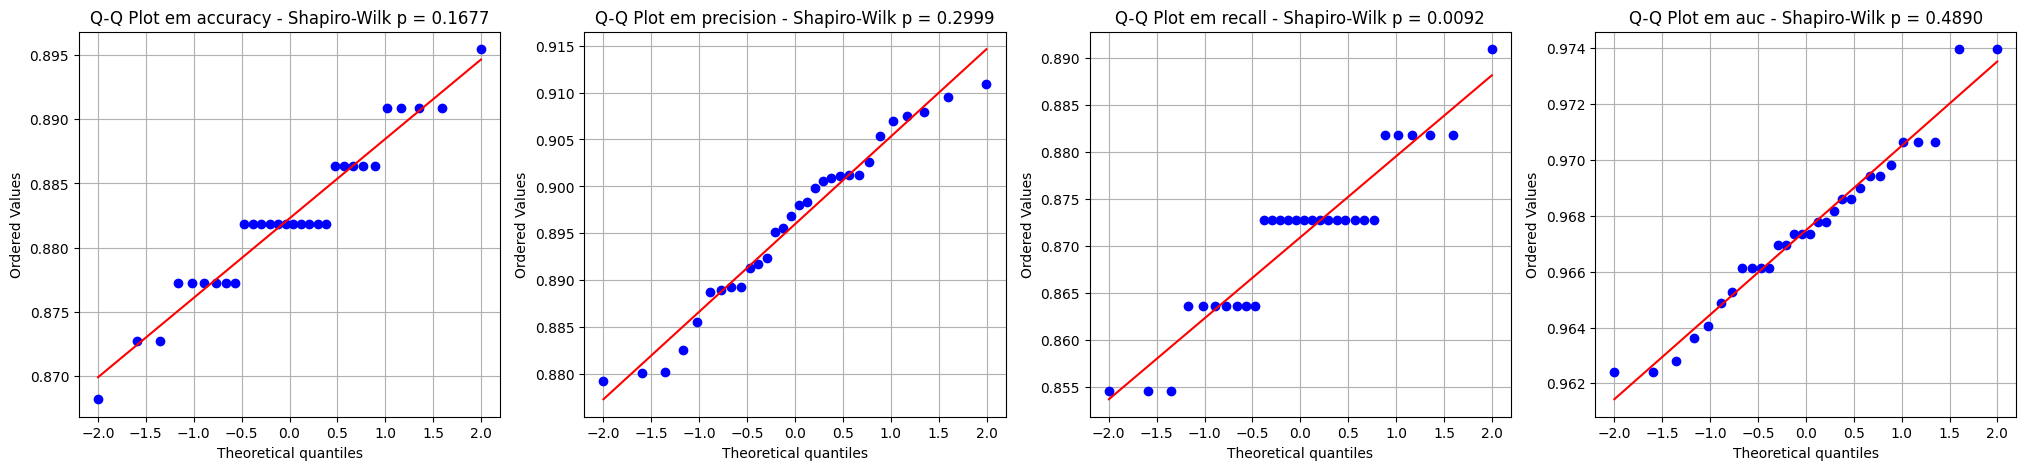

{'accuracy': 0.8822727272727274,
 'precision': 0.8959742934695013,
 'recall': 0.8709090909090907,
 'specificity': 0.8936363636363635,
 'auc': 0.9674793388429751}

In [35]:
class GaussianAnalyser:
    student = {
        1: 12.706, 2: 4.303, 3: 3.182, 4: 2.776, 5: 2.571, 6: 2.447, 7: 2.365, 8: 2.306,9: 2.262, 10: 2.228, 11: 2.201,
        12: 2.179, 13: 2.160, 14: 2.145, 15: 2.131, 16: 2.120, 17: 2.110, 18: 2.101, 19: 2.093, 20: 2.086, 21: 2.080,
        22: 2.074, 23: 2.069, 24: 2.064, 25: 2.060, 26: 2.056, 27: 2.052, 28: 2.048, 29: 2.045, 30: 2.042, 40: 2.021,
        60: 2.000, 80: 1.990, 100: 1.984, 120: 1.980, "infty": 1.960
    }

    metric_labels = ['accuracy','precision', 'recall', 'specificity', 'auc']

    def __init__(self, trainer, n=30):
        self.trainer = trainer
        self.n = n

    def update(self):
        self.metrics      = {metric: [] for metric in self.metric_labels}
        self.trainer.seed = None

        for i in range(self.n):
            self.trainer.update()
            info = self.trainer.info()
            
            for name in self.metric_labels:
                self.metrics[name].append(info[name])

    def info(self):
        response = {}

        for metric, values in self.metrics.items():
            response[metric] = float(np.mean(values))

        return response

    def gaussian(self, metric):
        data  = np.array(self.metrics[metric])
        mu    = data.mean()
        sigma = data.std(ddof=1)

        x  = np.linspace(mu - 4*sigma, mu + 4*sigma, 400)
        y  = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mu)/sigma)**2)
        dx = (x[1] - x[0])
        p  = (y * dx)

        t = self.student[self.n-1] if self.n < 120 else self.student["infty"]
        x_crit = t * sigma / np.sqrt(self.n)

        plt.title(f'Distribuição em {metric.title()}')
        plt.hist(data, density=True, alpha=0.75)
        plt.plot(x, y)
        plt.plot([(mu - x_crit) for i in x], np.linspace(0, max(y), len(x)), '--', color='red', label='$+t_{crit}$ (95%)')
        plt.plot([(mu + x_crit) for i in x], np.linspace(0, max(y), len(x)), '--', color='red', label='$-t_{crit}$ (95%)')
        
        text = f'média: {mu:.3f}\nmediana: {np.median(data):.3f}\nstd: {np.std(data):.3f}'
        opts = dict(boxstyle='round', facecolor='white', alpha=0.8)
        
        plt.text(0.05, 0.95, text, transform=plt.gca().transAxes, verticalalignment='top', bbox=opts)
        plt.xlabel('x'); plt.ylabel('frequência'); plt.grid(); plt.legend()

    def qqplot(self, key):
        data = np.array(self.metrics[key])
        stats.probplot(data, dist="norm", plot=plt)
        stat, p = stats.shapiro(data)
        plt.title(f"Q-Q Plot em {key} - Shapiro-Wilk p = {p:.4f}")
        plt.grid()

    def plot(self):
        plt.figure(figsize=(25, 5))
        plt.subplot(1, 4, 1); self.gaussian('accuracy')
        plt.subplot(1, 4, 2); self.gaussian('precision')
        plt.subplot(1, 4, 3); self.gaussian('recall')
        plt.subplot(1, 4, 4); self.gaussian('auc')
        plt.show()

        plt.figure(figsize=(25, 5))
        plt.subplot(1, 4, 1); self.qqplot('accuracy')
        plt.subplot(1, 4, 2); self.qqplot('precision')
        plt.subplot(1, 4, 3); self.qqplot('recall')
        plt.subplot(1, 4, 4); self.qqplot('auc')
        plt.show()


cross    = CrossValidation(model, xData, yData, K_CV)
analyser = GaussianAnalyser(cross)
analyser.update()
analyser.plot()
analyser.info()

# GRID SEARCH

In [36]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

In [37]:
class GridSearch:
    def __init__(self, model, xData, yData):
        self.model = clone(model)
        self.xData = xData
        self.yData = yData

    def update(self):
        xTrain, xTest, yTrain, yTest = train_test_split(self.xData, self.yData, test_size=0.20, stratify=yData, random_state=42)
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        grid = GridSearchCV(model, params, cv=cv_splitter, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid.fit(xTrain, yTrain)

        _, self.auc = getAUC(grid.best_estimator_, xTest, yTest)
        self.grid   = grid


grid = GridSearch(model, xData, yData)
grid.update()

print(grid.auc)
grid = grid.grid
grid.best_estimator_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
0.9938016528925621


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l1'
,dual,False
,tol,0.0001
,C,7


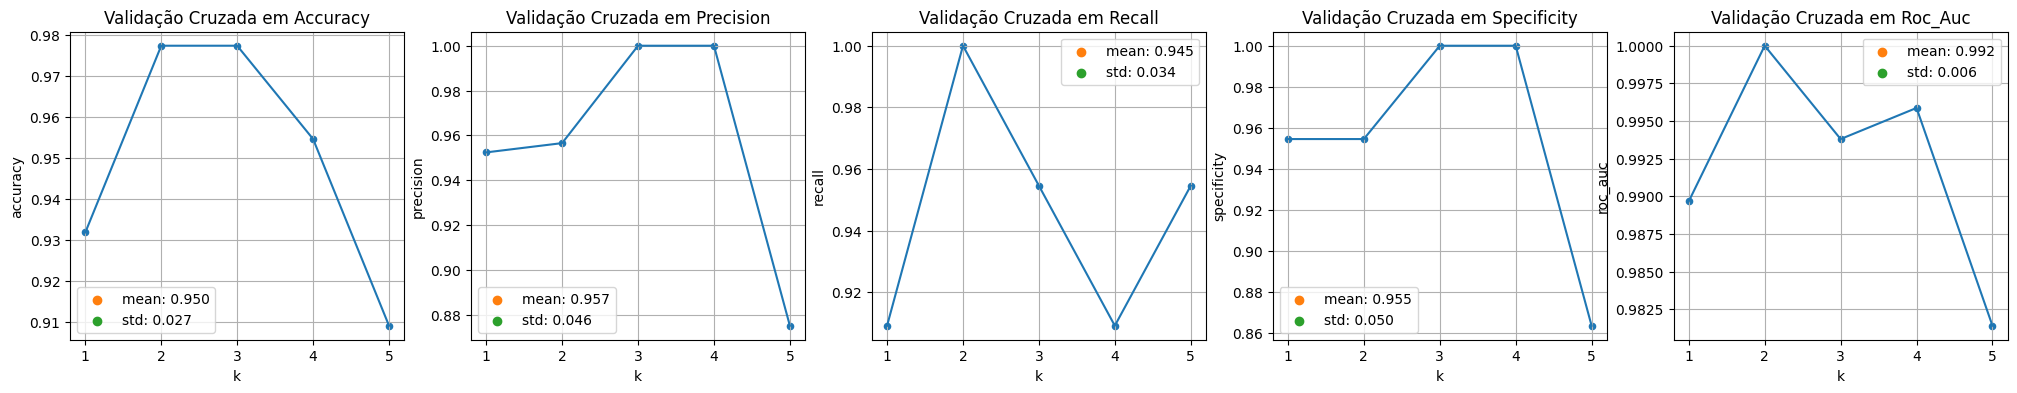

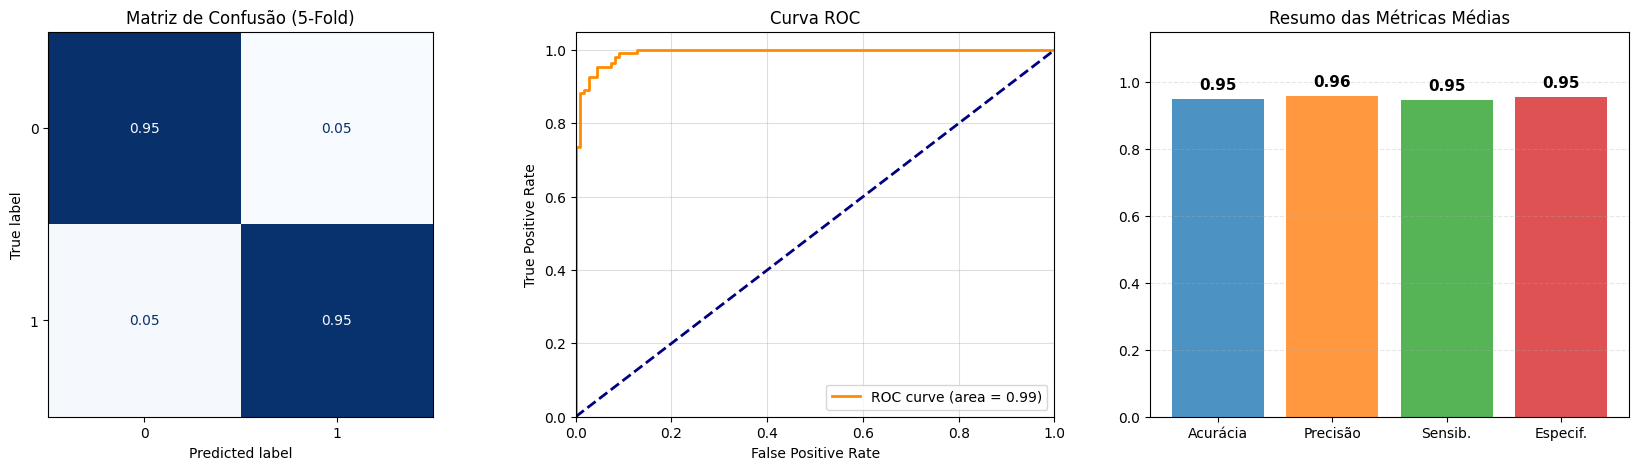

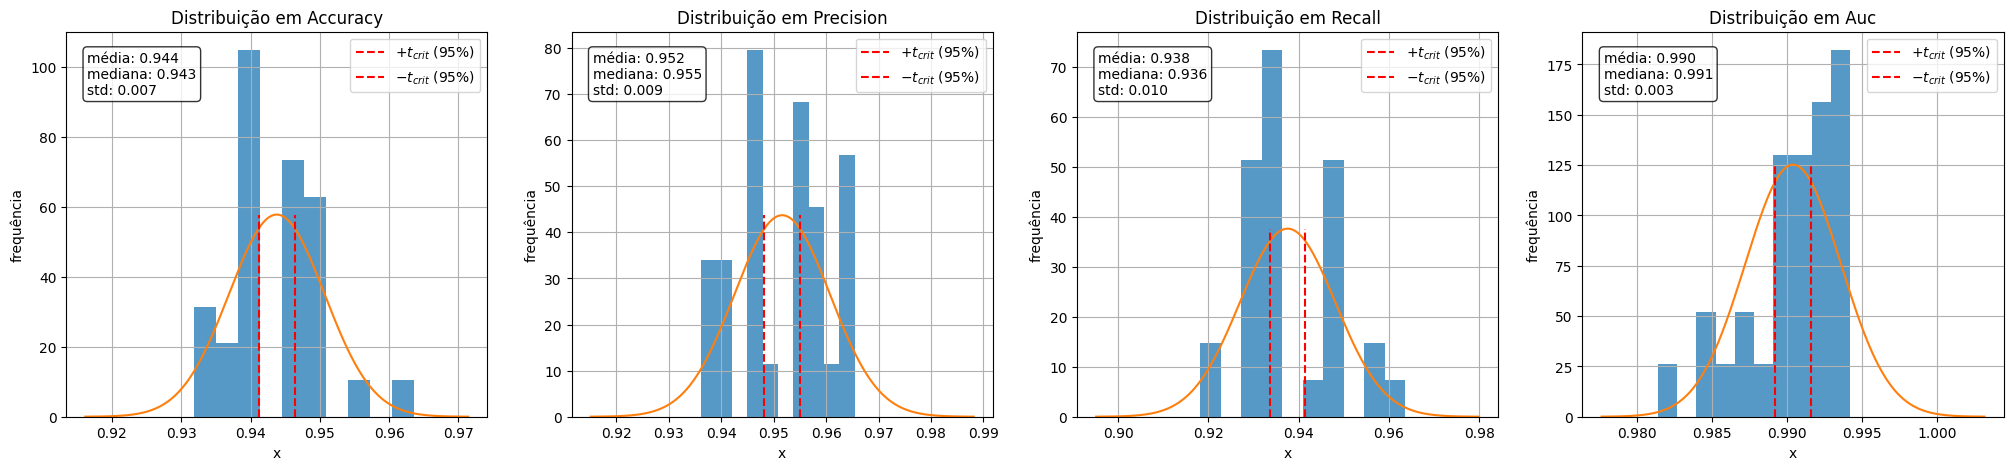

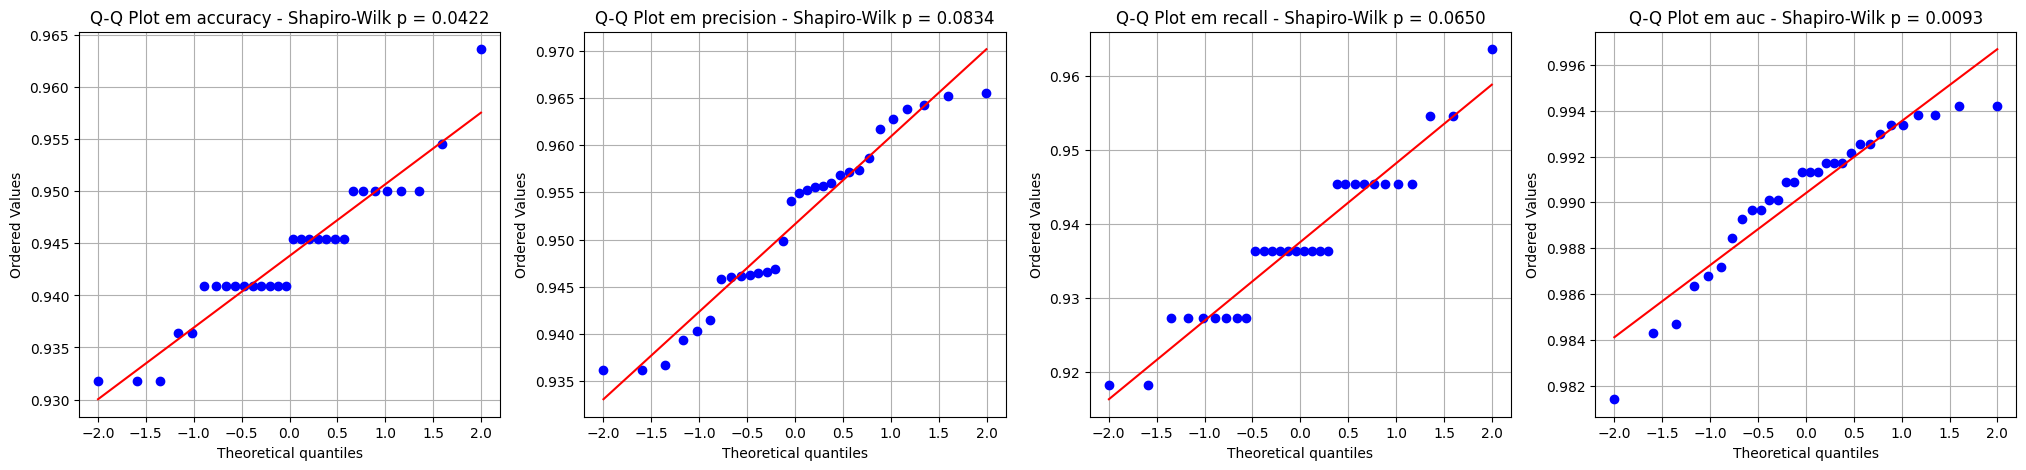

{'accuracy': 0.9437878787878788,
 'precision': 0.95162624461732,
 'recall': 0.9375757575757574,
 'specificity': 0.9500000000000001,
 'auc': 0.9903994490358127}

In [38]:
cross    = CrossValidation(grid.best_estimator_, xData, yData, K_CV)
analyser = GaussianAnalyser(cross)

cross.update()
cross.plot()

analyser.update()
analyser.plot()
analyser.info()

# VERIFICAÇÃO DE VARIÁVEIS

In [39]:
class VariableRemover:
    def __init__(self, model, xData, yData, k=5):
        self.model = clone(model)
        self.xData = xData
        self.yData = yData
        self.k  = k
        self.history = []

        analyser = GaussianAnalyser(CrossValidation(model, xData, yData, k=self.k))
        analyser.update()
        self.baseAUC = float(analyser.info().get('auc'))
        print(f"Base AUC: {self.baseAUC:.5f}")

    def getAUC(self, X, Y):
        analyser = GaussianAnalyser(CrossValidation(self.model, X, Y, k=self.k))
        analyser.update()
        return analyser.info().get('auc')

    def update(self):       
        variables    = self.xData.columns.tolist()
        self.history = []

        for variable in variables:
            X      = self.xData.drop(columns=[variable])
            newAUC = self.getAUC(X, self.yData)
            delta  = (newAUC - self.baseAUC)*100
            
            self.history.append({
                'removed': variable, 
                'auc':   round(newAUC, 5), 
                'delta': round(abs(delta), 5)
            })


#remover = VariableRemover(grid.best_estimator_, xData, yData, K_CV)
#remover.update()
#pd.DataFrame(remover.history)

# TREINANDO MODELO FINAL

In [40]:
model = clone(grid.best_estimator_)
model.fit(xData, yData)
model.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('model',
   LogisticRegression(C=7, max_iter=50, penalty='l1', solver='liblinear'))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'model': LogisticRegression(C=7, max_iter=50, penalty='l1', solver='liblinear'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__C': 7,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 50,
 'model__multi_class': 'deprecated',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'liblinear',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [41]:
df.head()

,min,std,median,last,mean,max,first,alcohol,data
0,23250,742.479449,23281.0,23275,23557.723404,26216,23534,False,"[23534, 24013, 26216, 26172, 26108, 25037, 240..."
1,23536,748.382989,23585.0,23596,23877.446809,26143,23797,False,"[23797, 24164, 26134, 26143, 26142, 26120, 253..."
2,23695,749.516802,23765.0,23801,24055.574468,26359,23899,False,"[23899, 24905, 26249, 26359, 26335, 26225, 254..."
3,23523,941.151691,23586.0,23553,24066.489362,26285,23967,False,"[23967, 24384, 26285, 26237, 26228, 26188, 261..."
4,23826,715.797389,23938.0,23943,24297.723404,26269,23859,False,"[23859, 24287, 26269, 26188, 26115, 25477, 245..."


In [42]:
def getAlcohol(row):
    #return row['model']
    return (row['model'] and row['min'] < 19000)


df['model']  = model.predict(xData)
df['result'] = df.apply(lambda row: getAlcohol(row), axis=1)
print(f'acertos: {100*(df.result == df.alcohol).sum()/len(df):.2f}%')

acertos: 96.36%


In [43]:
data = {
    'model': model,
    'params': model.get_params(),
    'K_CV': K_CV,
    'results': analyser.info()
}

pd.DataFrame([data['results']])

,accuracy,precision,recall,specificity,auc
0,0.943788,0.951626,0.937576,0.95,0.990399


# ANÁLISE GRÁFICA

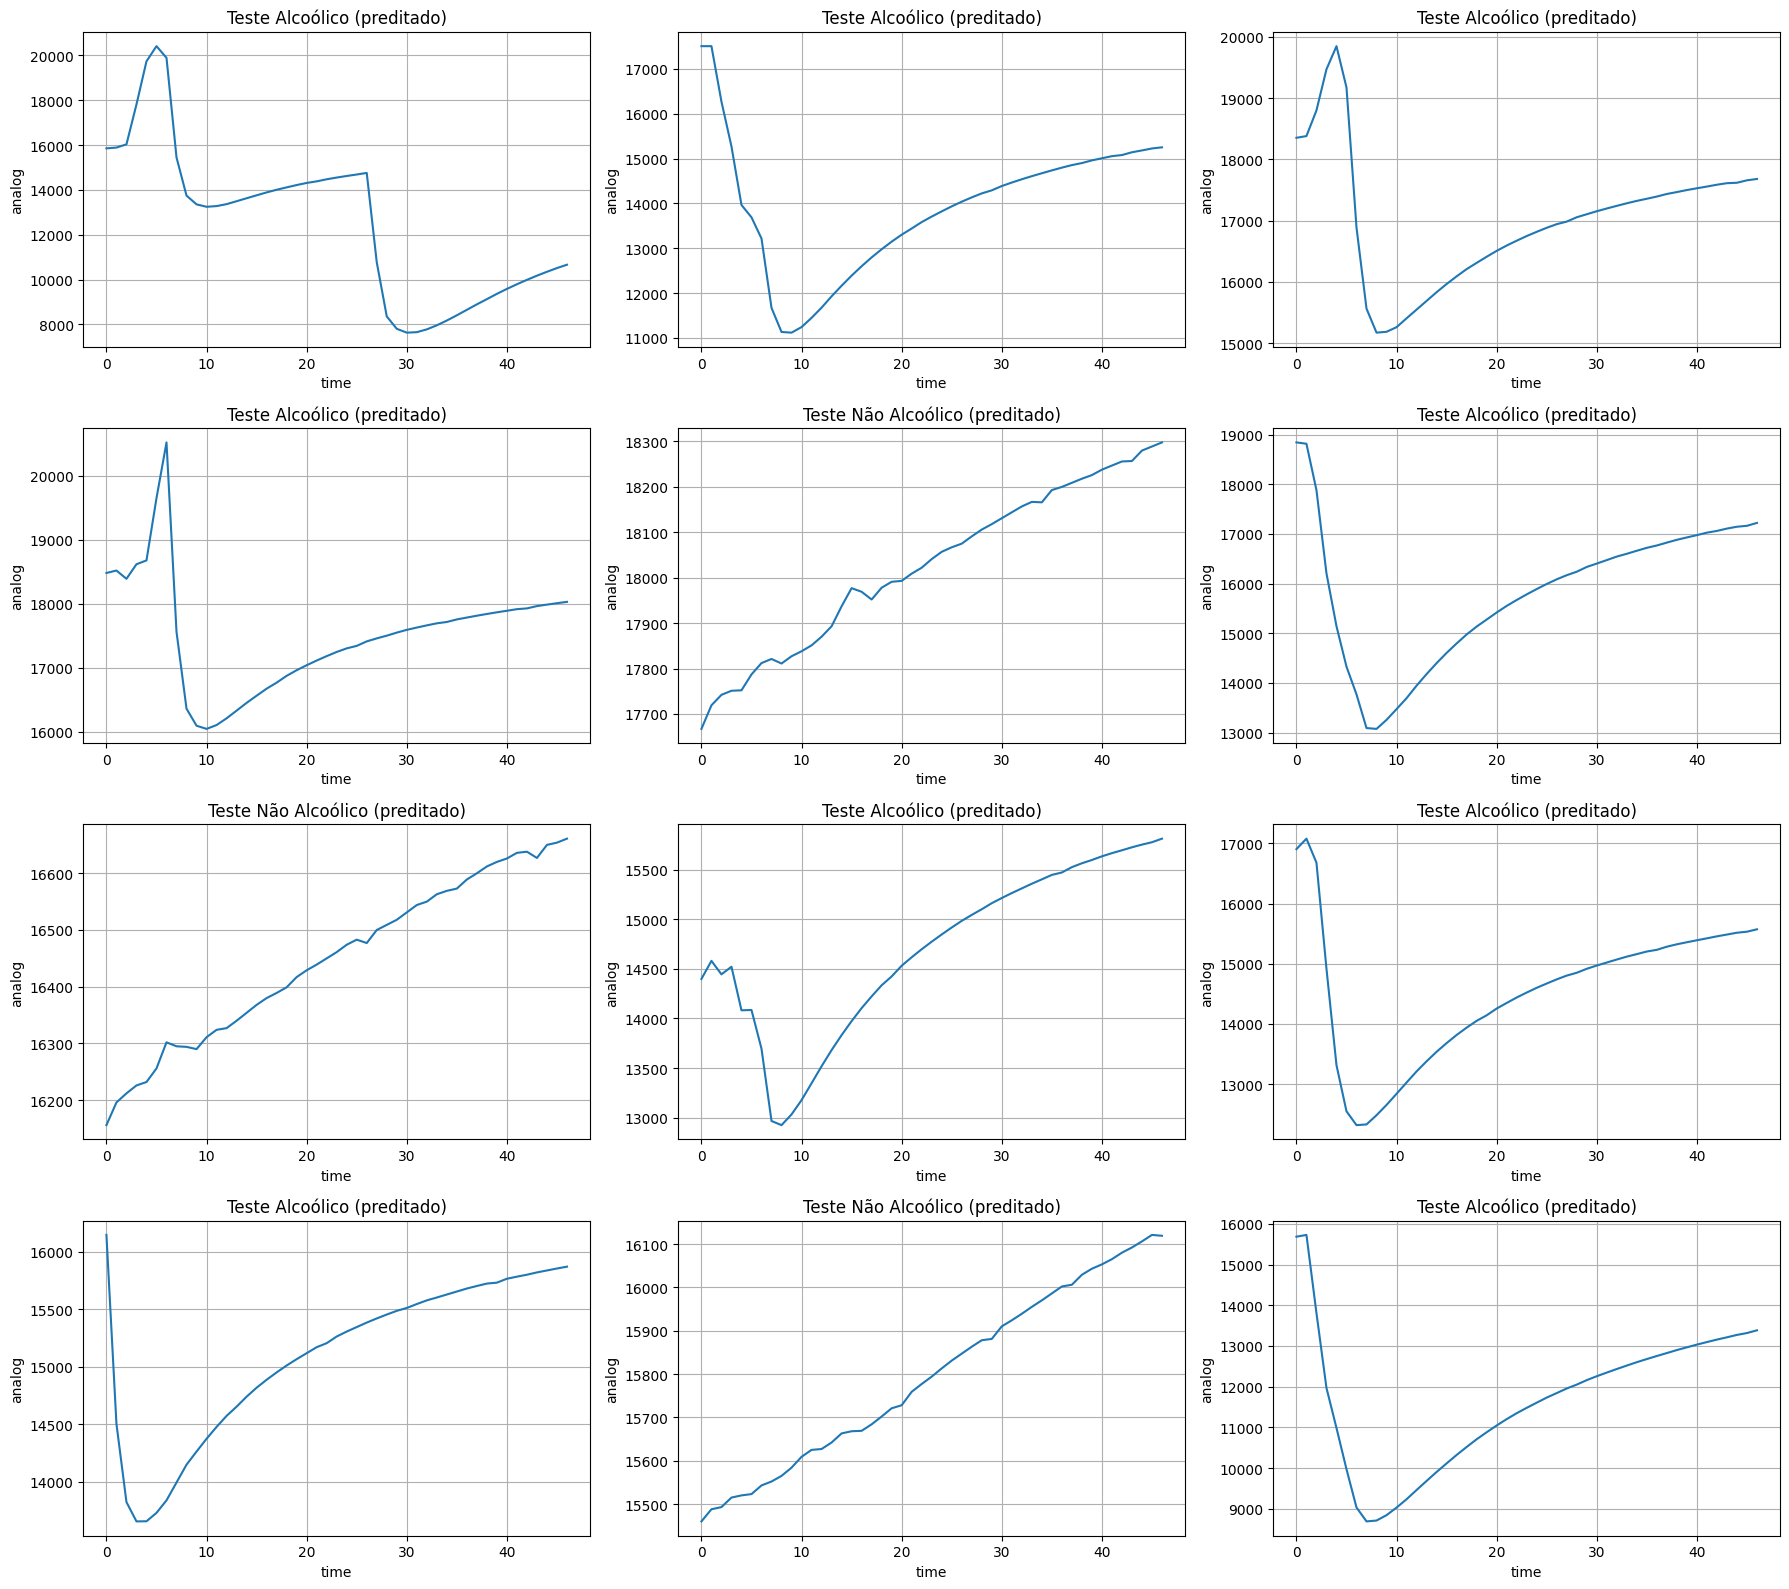

In [44]:
import math

def plotTables(df, limit=None):
    count = len(df) if limit is None else min(limit, len(df))
    numCols = 3 if count >= 3 else count
    numRows = math.ceil(count / numCols)
    plt.figure(figsize=(6*numCols, 4*numRows))

    for idx, (i, row) in enumerate(df.iterrows()):
        if idx >= count:
            break

        plt.subplot(numRows, numCols, idx + 1)
        plt.plot(row.data)
        title  = f'Teste {"Alcoólico" if row["alcohol"] else "Não Alcoólico"}'
        status = f'({"preditado" if row.alcohol == row.result else "divergente"})'
        
        plt.title(f'{title} {status}')
        plt.grid(), plt.xlabel('time'), plt.ylabel('analog')

    plt.tight_layout()
    plt.show()


plotTables(df.iloc[::-1].reset_index(drop=True), limit=12)

### PREDIÇÕES DIVERGENTES

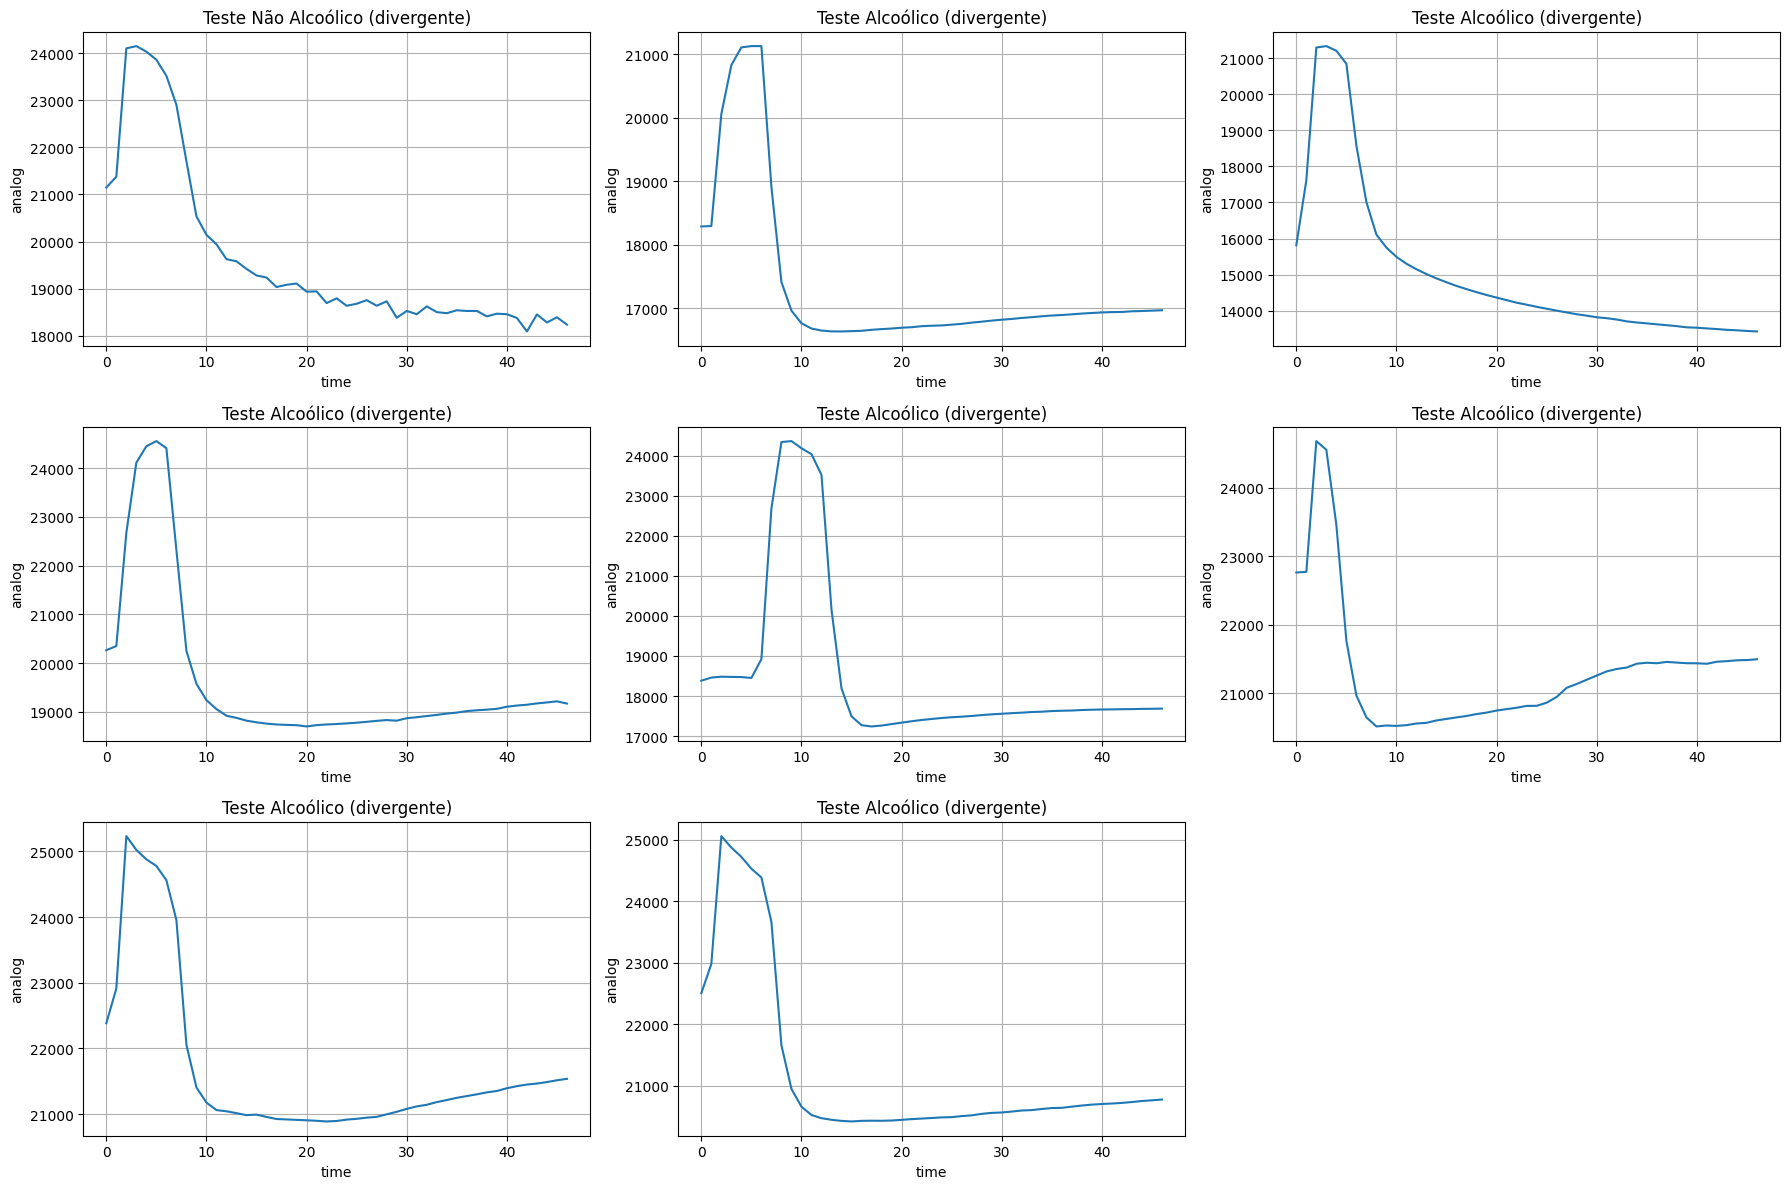

In [45]:
plotTables(df.loc[df.alcohol != df.result].iloc[::-1].reset_index(drop=True), limit=None)

# SISTEMA EMBARCADO

In [ ]:
print(', '.join(xData.columns.tolist()) + ';')

min, std, median, last, mean, max, first


In [47]:
scaler    = model.named_steps.get('scaler')
predictor = model.named_steps.get('model')

OFFSET  = scaler.mean_
GAIN    = 1.0 / scaler.scale_
WEIGHTS = predictor.coef_[0]
BIAS    = float(predictor.intercept_[0])

print(f'static const int size     = {len(OFFSET)};')
print('const float OFFSET[size]  = {' + ", ".join(map(str, OFFSET)) + '};')
print('const float GAIN[size]    = {' + ", ".join(map(str, GAIN))   + '};')
print(f'const float WEIGHTS[size] ' + "= {" + ", ".join(map(str, predictor.coef_[0])) + "};")
print(f'const float BIAS = ' + str(BIAS) + ";")

static const int size     = 7;
const float OFFSET[size]  = {15618.8, 1687.8615008274373, 16308.90909090909, 16333.254545454545, 16910.3165377176, 21693.104545454546, 18507.295454545456};
const float GAIN[size]    = {0.00019772276363206435, 0.001102698128052092, 0.00020780427624029606, 0.00020514848415886274, 0.00021758057726029318, 0.00026891899130671184, 0.0002502054579794916};
const float WEIGHTS[size] = {-8.215226636633838, 7.074733259760441, 0.0, 19.630304116985403, -18.843622276275063, -3.8972770395941336, 10.607430824152715};
const float BIAS = 3.234409180403022;


In [48]:
for i, column in enumerate(xData.columns):
    print(f'x[index++] = (float) {column}; // {column}')

x[index++] = (float) min; // min
x[index++] = (float) std; // std
x[index++] = (float) median; // median
x[index++] = (float) last; // last
x[index++] = (float) mean; // mean
x[index++] = (float) max; // max
x[index++] = (float) first; // first
